In [1]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import pmdarima as pm

In [2]:
pop = pd.read_csv('POP.csv', index_col='date')
pop.index = pd.to_datetime(pop.index)
pop.tail()

,realtime_start,value,realtime_end
date,,,
2019-08-01,2019-12-06,329591.333,2019-12-06
2019-09-01,2019-12-06,329785.872,2019-12-06
2019-10-01,2019-12-06,329982.035,2019-12-06
2019-11-01,2019-12-06,330154.949,2019-12-06
2019-12-01,2019-12-06,330309.946,2019-12-06


In [3]:
# Converter as colunas de datas para objetos DateTime
pop['realtime_start'] = pd.to_datetime(pop['realtime_start'])
pop['realtime_end'] = pd.to_datetime(pop['realtime_end'])

# Criar defasagens na coluna 'value'
for i in range(1, 4):  # Por exemplo, crie defasagens de 1 a 3 períodos
    pop[f'value_lag_{i}'] = pop['value'].shift(i)

# O resultado será um DataFrame com as defasagens da coluna 'value'


In [4]:
pop.tail()

,realtime_start,value,realtime_end,value_lag_1,value_lag_2,value_lag_3
date,,,,,,
2019-08-01,2019-12-06,329591.333,2019-12-06,329394.993,329213.989,329047.319
2019-09-01,2019-12-06,329785.872,2019-12-06,329591.333,329394.993,329213.989
2019-10-01,2019-12-06,329982.035,2019-12-06,329785.872,329591.333,329394.993
2019-11-01,2019-12-06,330154.949,2019-12-06,329982.035,329785.872,329591.333
2019-12-01,2019-12-06,330309.946,2019-12-06,330154.949,329982.035,329785.872


In [5]:
pop['realtime_start'] = pd.to_datetime(pop['realtime_start'])
pop['realtime_end'] = pd.to_datetime(pop['realtime_end'])

In [6]:
pop.tail()

,realtime_start,value,realtime_end,value_lag_1,value_lag_2,value_lag_3
date,,,,,,
2019-08-01,2019-12-06,329591.333,2019-12-06,329394.993,329213.989,329047.319
2019-09-01,2019-12-06,329785.872,2019-12-06,329591.333,329394.993,329213.989
2019-10-01,2019-12-06,329982.035,2019-12-06,329785.872,329591.333,329394.993
2019-11-01,2019-12-06,330154.949,2019-12-06,329982.035,329785.872,329591.333
2019-12-01,2019-12-06,330309.946,2019-12-06,330154.949,329982.035,329785.872


In [7]:

from sklearn.model_selection import train_test_split

# Escolha o número de observações que você deseja usar como dados de treinamento
train_size = 0.8  # Por exemplo, 80% dos dados para treinamento

# Determine o índice de corte para a divisão entre treinamento e teste
split_index = int(len(pop) * train_size)

# Divida os dados em conjuntos de treinamento e teste
train = pop[:split_index]  # Dados de treinamento
test = pop[split_index:]   # Dados de teste

# Agora, 'train_data' contém os dados de treinamento e 'test_data' contém os dados de teste

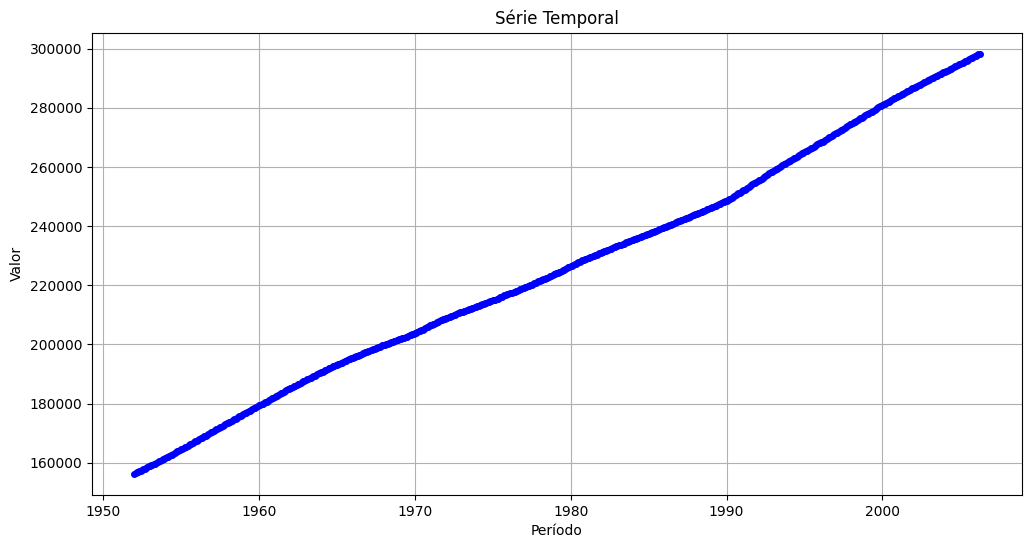

In [8]:
# Plotando o gráfico de série temporal
plt.figure(figsize=(12, 6))  # Define o tamanho da figura
plt.plot(train.index, train['value'], color='b', linestyle='-', marker='o', markersize=4)
plt.xlabel('Período')  # Rótulo para o eixo x
plt.ylabel('Valor')  # Rótulo para o eixo y
plt.title('Série Temporal')  # Título do gráfico
plt.grid(True)  # Adiciona uma grade ao gráfico
plt.show()  # Mostra o gráfico

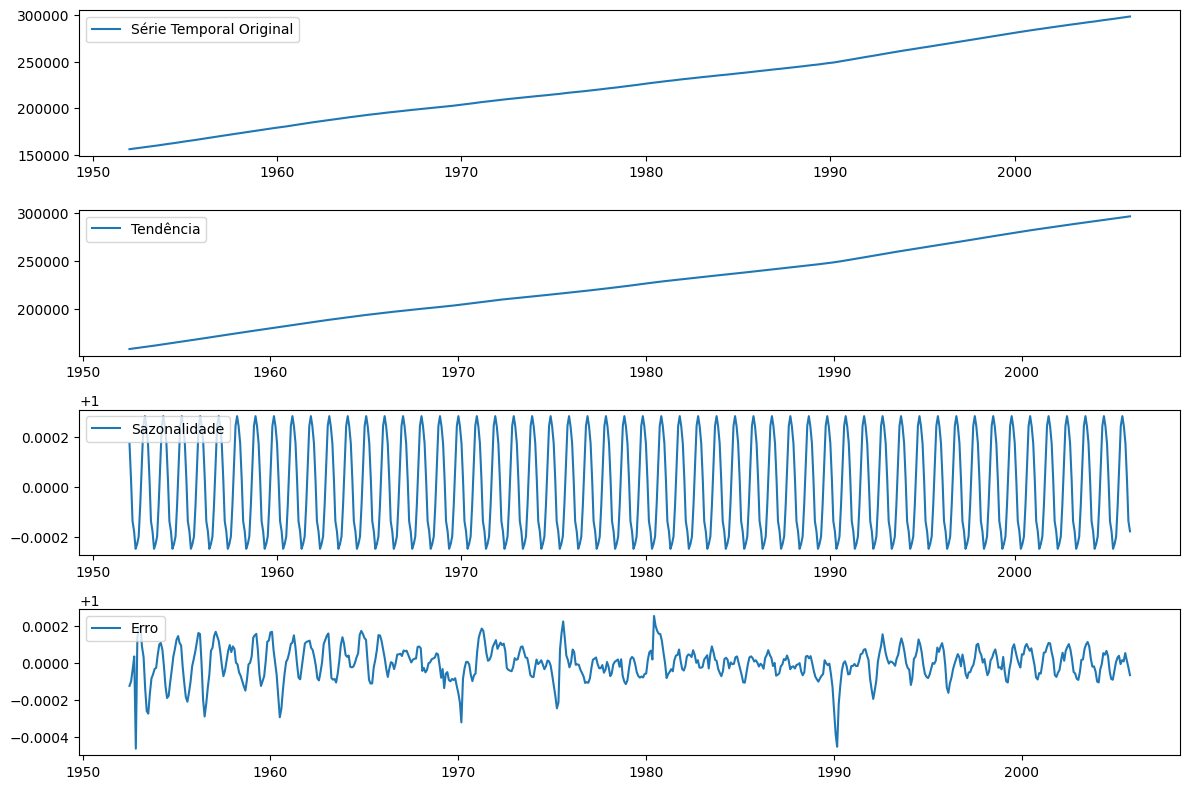

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Realize a decomposição
result = seasonal_decompose(train['value'], model='multiplicative') #additive ou multiplicative

# Obtenha as componentes da decomposição
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plotando as componentes da decomposição
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(train['value'], label='Série Temporal Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendência')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Erro')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

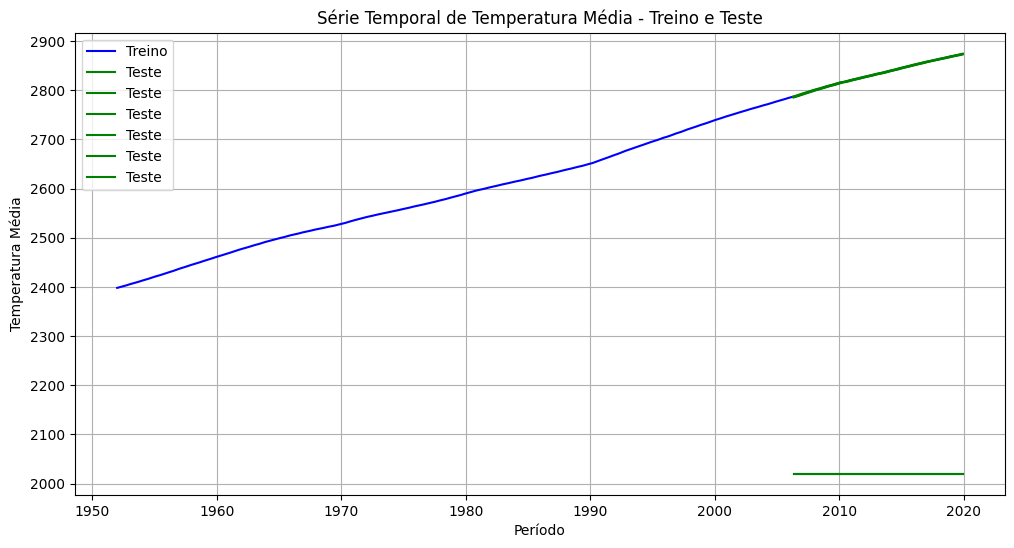

In [10]:
# Plotando as séries temporais
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Treino', color='blue')
plt.plot(test.index, test, label='Teste', color='green')
plt.xlabel('Período')
plt.ylabel('Temperatura Média')
plt.title('Série Temporal de Temperatura Média - Treino e Teste')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [11]:
# Passo 1: separando X e Y e normalizando os dados

X = train[["realtime_start", "realtime_end"]]
y = train["value"]

# Normalização dos dados
# Normalize os dados (opcional, mas pode melhorar o desempenho da rede)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Converta os dados para o formato 3D esperado pela LSTM (samples, timesteps, features)
# Nesse caso, como temos apenas uma variável explicativa (3 features), definimos timesteps = 1.
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

In [12]:
len(X),len(y)

(652, 652)

In [13]:
X_lstm.shape #652 linhas na base, por 1 data, com 2 variáveis explicativas em cada data

(652, 1, 2)

In [14]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model1 = Sequential()
model1.add(LSTM(units=50, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model1.add(Dense(units=1))

# Passo 3: Compile o modelo

model1.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history1 = model1.fit(X_lstm, y_scaled, epochs=200, batch_size=16)

Epoch 1/200
41/41 [==============================] - 1s 937us/step - loss: 0.2992
Epoch 2/200
41/41 [==============================] - 0s 888us/step - loss: 0.2640
Epoch 3/200
41/41 [==============================] - 0s 894us/step - loss: 0.2328
Epoch 4/200
41/41 [==============================] - 0s 874us/step - loss: 0.2056
Epoch 5/200
41/41 [==============================] - 0s 887us/step - loss: 0.1824
Epoch 6/200
41/41 [==============================] - 0s 900us/step - loss: 0.1626
Epoch 7/200
41/41 [==============================] - 0s 895us/step - loss: 0.1459
Epoch 8/200
41/41 [==============================] - 0s 871us/step - loss: 0.1318
Epoch 9/200
41/41 [==============================] - 0s 895us/step - loss: 0.1204
Epoch 10/200
41/41 [==============================] - 0s 894us/step - loss: 0.1109
Epoch 11/200
41/41 [==============================] - 0s 871us/step - loss: 0.1032
Epoch 12/200
41/41 [==============================] - 0s 846us/step - loss: 0.0971
Epoch 13/200


In [15]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model2 = Sequential()
model2.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model2.add(Dense(units=1))

# Passo 3: Compile o modelo

model2.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history2 = model2.fit(X_lstm, y_scaled, epochs=200, batch_size=32)

Epoch 1/200
21/21 [==============================] - 1s 1ms/step - loss: 0.3078
Epoch 2/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2883
Epoch 3/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2700
Epoch 4/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2529
Epoch 5/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2370
Epoch 6/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2221
Epoch 7/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2085
Epoch 8/200
21/21 [==============================] - 0s 1ms/step - loss: 0.1957
Epoch 9/200
21/21 [==============================] - 0s 1ms/step - loss: 0.1842
Epoch 10/200
21/21 [==============================] - 0s 1ms/step - loss: 0.1733
Epoch 11/200
21/21 [==============================] - 0s 1ms/step - loss: 0.1635
Epoch 12/200
21/21 [==============================] - 0s 1ms/step - loss: 0.1544
Epoch 13/200
21/21 [=================

In [16]:
# Passo 2: Crie o modelo LSTM usando TensorFlow

model3 = Sequential()
model3.add(LSTM(units=100, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model3.add(Dense(units=1))

# Passo 3: Compile o modelo

model3.compile(loss='mean_squared_error', optimizer='adam')

# Passo 4: Treine o modelo

history3 = model3.fit(X_lstm, y_scaled, epochs=200, batch_size=128)

Epoch 1/200
6/6 [==============================] - 1s 2ms/step - loss: 0.3152
Epoch 2/200
6/6 [==============================] - 0s 1ms/step - loss: 0.3094
Epoch 3/200
6/6 [==============================] - 0s 2ms/step - loss: 0.3037
Epoch 4/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2981
Epoch 5/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2925
Epoch 6/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2870
Epoch 7/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2816
Epoch 8/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2764
Epoch 9/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2712
Epoch 10/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2662
Epoch 11/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2613
Epoch 12/200
6/6 [==============================] - 0s 2ms/step - loss: 0.2565
Epoch 13/200
6/6 [==============================] - 0s 2ms/st

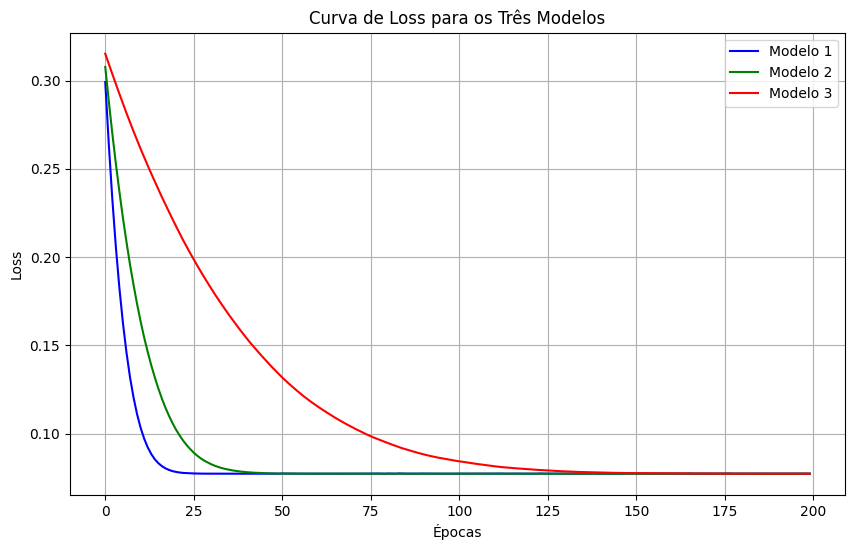

In [17]:
# Supondo que você tenha os objetos "history1", "history2" e "history3", que contêm informações sobre o treinamento dos três modelos.

# Plotando as curvas de loss
plt.figure(figsize=(10, 6))

plt.plot(history1.history['loss'], label='Modelo 1', color='blue')
plt.plot(history2.history['loss'], label='Modelo 2', color='green')
plt.plot(history3.history['loss'], label='Modelo 3', color='red')

plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Curva de Loss para os Três Modelos')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Passo 1: Pré-processamento dos novos dados de teste

# Divida os dados em variáveis de entrada (X) e variável de saída (y), similar ao que você fez para os dados de treinamento.
X_test = pop[["realtime_start", "realtime_end"]]

# Normalize os dados usando o mesmo scaler que você usou para os dados de treinamento.
X_test_scaled = scaler_X.transform(X_test)

# Converta os dados para o formato 3D esperado pela LSTM
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Passo 2: Fazer previsões com o modelo LSTM

# Use o método predict para fazer as previsões
y_pred_scaled1 = model1.predict(X_test_lstm)
y_pred_scaled2 = model2.predict(X_test_lstm)
y_pred_scaled3 = model3.predict(X_test_lstm)

# Como o modelo retorna as previsões em escala, desfaça a normalização para obter as previsões reais
y_pred1 = scaler_y.inverse_transform(y_pred_scaled1)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)
y_pred3 = scaler_y.inverse_transform(y_pred_scaled3)

26/26 [==============================] - 0s 682us/step


In [19]:
# Calcule o RMSE para cada modelo
rmse_model1 = np.sqrt(np.mean((np.array(pop['value']) - y_pred1) ** 2))
rmse_model2 = np.sqrt(np.mean((np.array(pop['value']) - y_pred2) ** 2))
rmse_model3 = np.sqrt(np.mean((np.array(pop['value']) - y_pred3) ** 2))

print('RMSE Modelo 1:', rmse_model1)
print('RMSE Modelo 2:', rmse_model2)
print('RMSE Modelo 3:', rmse_model3)

RMSE Modelo 1: 53648.42012896458
RMSE Modelo 2: 53555.518251910966
RMSE Modelo 3: 53632.49803302443


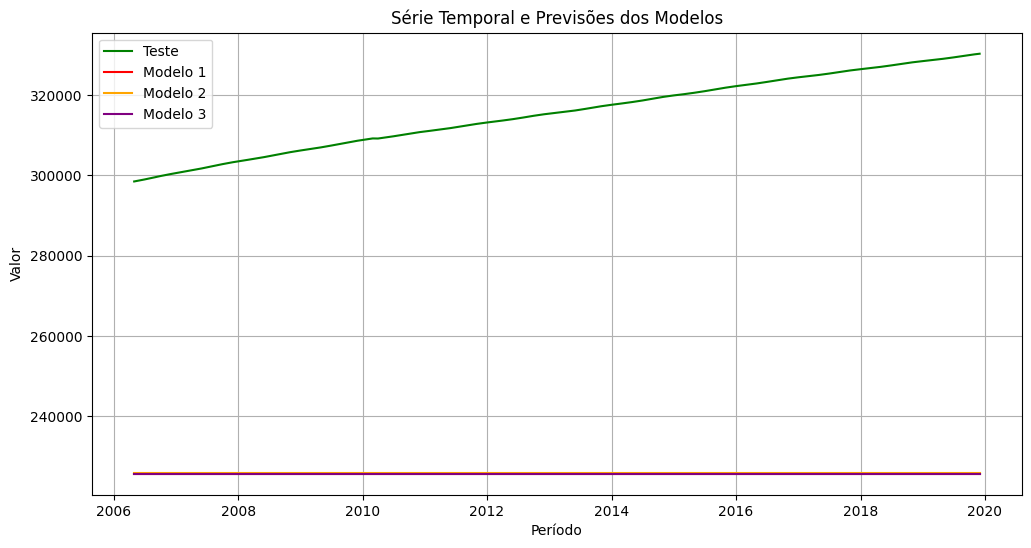

In [20]:
# Plotando a série temporal da coluna "meantemp" da base de treino e teste
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['value'], label='Teste', color='green')

# Plotando as previsões dos modelos em cores diferentes
plt.plot(test.index, y_pred1[:len(test)], label='Modelo 1', color='red')
plt.plot(test.index, y_pred2[:len(test)], label='Modelo 2', color='orange')
plt.plot(test.index, y_pred3[:len(test)], label='Modelo 3', color='purple')

plt.xlabel('Período')
plt.ylabel('Valor')
plt.title('Série Temporal e Previsões dos Modelos')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
